In [2]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import train_test_split as tts


train_test30 = pd.read_csv('train_test_filtered_v2.csv')
oot30 = pd.read_csv('oot_filtered_v2.csv')

X = train_test30.drop('Fraud', axis = 1)
y = train_test30['Fraud']

num_iter = 7

results_dict = {}
keys = ['run1', 'run2', 'run3', 'run4', 'run5', 'run6', 'run7']

#begin loop
for j in range(0,num_iter):
    X_train, X_test, y_train, y_test = tts(X, y, test_size = .3, stratify = y, random_state = j)

    bt1_X_train = X_train.copy()
    bt1_X_test = X_test.copy()
    bt1_oot = oot30.copy().drop('Fraud', axis=1)
    bt1 = GBC(n_estimators = 500, max_depth = 6, learning_rate = 0.01).fit(bt1_X_train, y_train)

    bt2_X_train = X_train.copy()
    bt2_X_test = X_test.copy()
    bt2_oot = oot30.copy().drop('Fraud', axis=1)
    bt2 = GBC(n_estimators = 500, max_depth = 4, learning_rate = 0.01).fit(bt2_X_train, y_train)

    bt3_X_train = X_train.copy()
    bt3_X_test = X_test.copy()
    bt3_oot = oot30.copy().drop('Fraud', axis=1)
    bt3 = GBC(n_estimators = 700, max_depth = 4, learning_rate = 0.01).fit(bt3_X_train, y_train)


    modList = [bt1, bt2, bt3]
    train_list = [bt1_X_train, 
                 bt2_X_train, bt3_X_train] 
    test_list = [bt1_X_test,\
                bt2_X_test, bt3_X_test]
    oot_list = [bt1_oot, bt2_oot, bt3_oot]


## Determine FDR @ 3% 

### On the training data...

    training_FDRs = []
    i = 0
    for model in modList:
        train_set = train_list[i]
        i+=1
        temp = train_set.copy()
        temp['scores'] = 0
        temp['scores'] = model.predict_proba(train_set)
        cutpoint = int(len(temp)*(.03))
        top3percent = temp.sort_values(by = 'scores', ascending = True).iloc[:cutpoint,:]
        FDR = train_test30.loc[top3percent.index, 'Fraud'].sum()/train_test30.loc[train_set.index, 'Fraud'].sum()
        training_FDRs.append(FDR)

    ### On the testing data...

    testing_FDRs = []
    i = 0
    for model in modList:
        test_set = test_list[i]
        i+=1
        temp = test_set.copy()
        temp['scores'] = 0
        temp['scores'] = model.predict_proba(test_set)
        cutpoint = int(len(temp)*(.03))
        top3percent = temp.sort_values(by = 'scores', ascending = True).iloc[:cutpoint,:]
        FDR = train_test30.loc[top3percent.index, 'Fraud'].sum()/train_test30.loc[test_set.index, 'Fraud'].sum()
        testing_FDRs.append(FDR)

    ### And on the OOT data...

    oot_FDRs = []
    i = 0
    for model in modList:
        oot_set = oot_list[i]
        i+=1
        temp = oot_set.copy()
        temp['scores'] = 0
        temp['scores'] = model.predict_proba(oot_set)
        cutpoint = int(len(temp)*(.03))
        top3percent = temp.sort_values(by = 'scores', ascending = True).iloc[:cutpoint,:]
        FDR = oot30.loc[top3percent.index, 'Fraud'].sum()/oot30['Fraud'].sum()
        oot_FDRs.append(FDR)

    FDRdict = {'Model': modList, 'trainingFDR':training_FDRs, 'testingFDR':testing_FDRs, 'ootFDR':oot_FDRs}
    modelFDRs = pd.DataFrame(FDRdict)
    
    key = keys[j]

    results_dict[key] = modelFDRs


In [3]:
final_results_df = pd.DataFrame(columns = ['Model', 'trainingFDR', 'testingFDR', 'ootFDR'])
final_results_df['Model'] = results_dict['run2']['Model']
for col in ['trainingFDR', 'testingFDR', 'ootFDR']:
    final_results_df[col] = 0

for key in results_dict.keys():
    
    df = results_dict[key]
    
    for row in range(0, 3):
        for col in ['trainingFDR', 'testingFDR', 'ootFDR']:
            
            final_results_df.loc[row, col] = final_results_df[col][row] + df[col][row]
            

for row in range(0, 3):
        for col in ['trainingFDR', 'testingFDR', 'ootFDR']:
            final_results_df[col][row] = final_results_df[col][row]/num_iter
            
final_results_df

<ipython-input-3-8b8f1caaa289>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_results_df[col][row] = final_results_df[col][row]/num_iter


,Model,trainingFDR,testingFDR,ootFDR
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.987083,0.946956,0.581519
1,([DecisionTreeRegressor(criterion='friedman_ms...,0.915784,0.900542,0.597982
2,([DecisionTreeRegressor(criterion='friedman_ms...,0.941617,0.913201,0.601699


In [4]:
results_dict['run2']

,Model,trainingFDR,testingFDR,ootFDR
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.989150,0.949367,0.665428
1,([DecisionTreeRegressor(criterion='friedman_ms...,0.915009,0.915612,0.672862
2,([DecisionTreeRegressor(criterion='friedman_ms...,0.942134,0.932489,0.661710


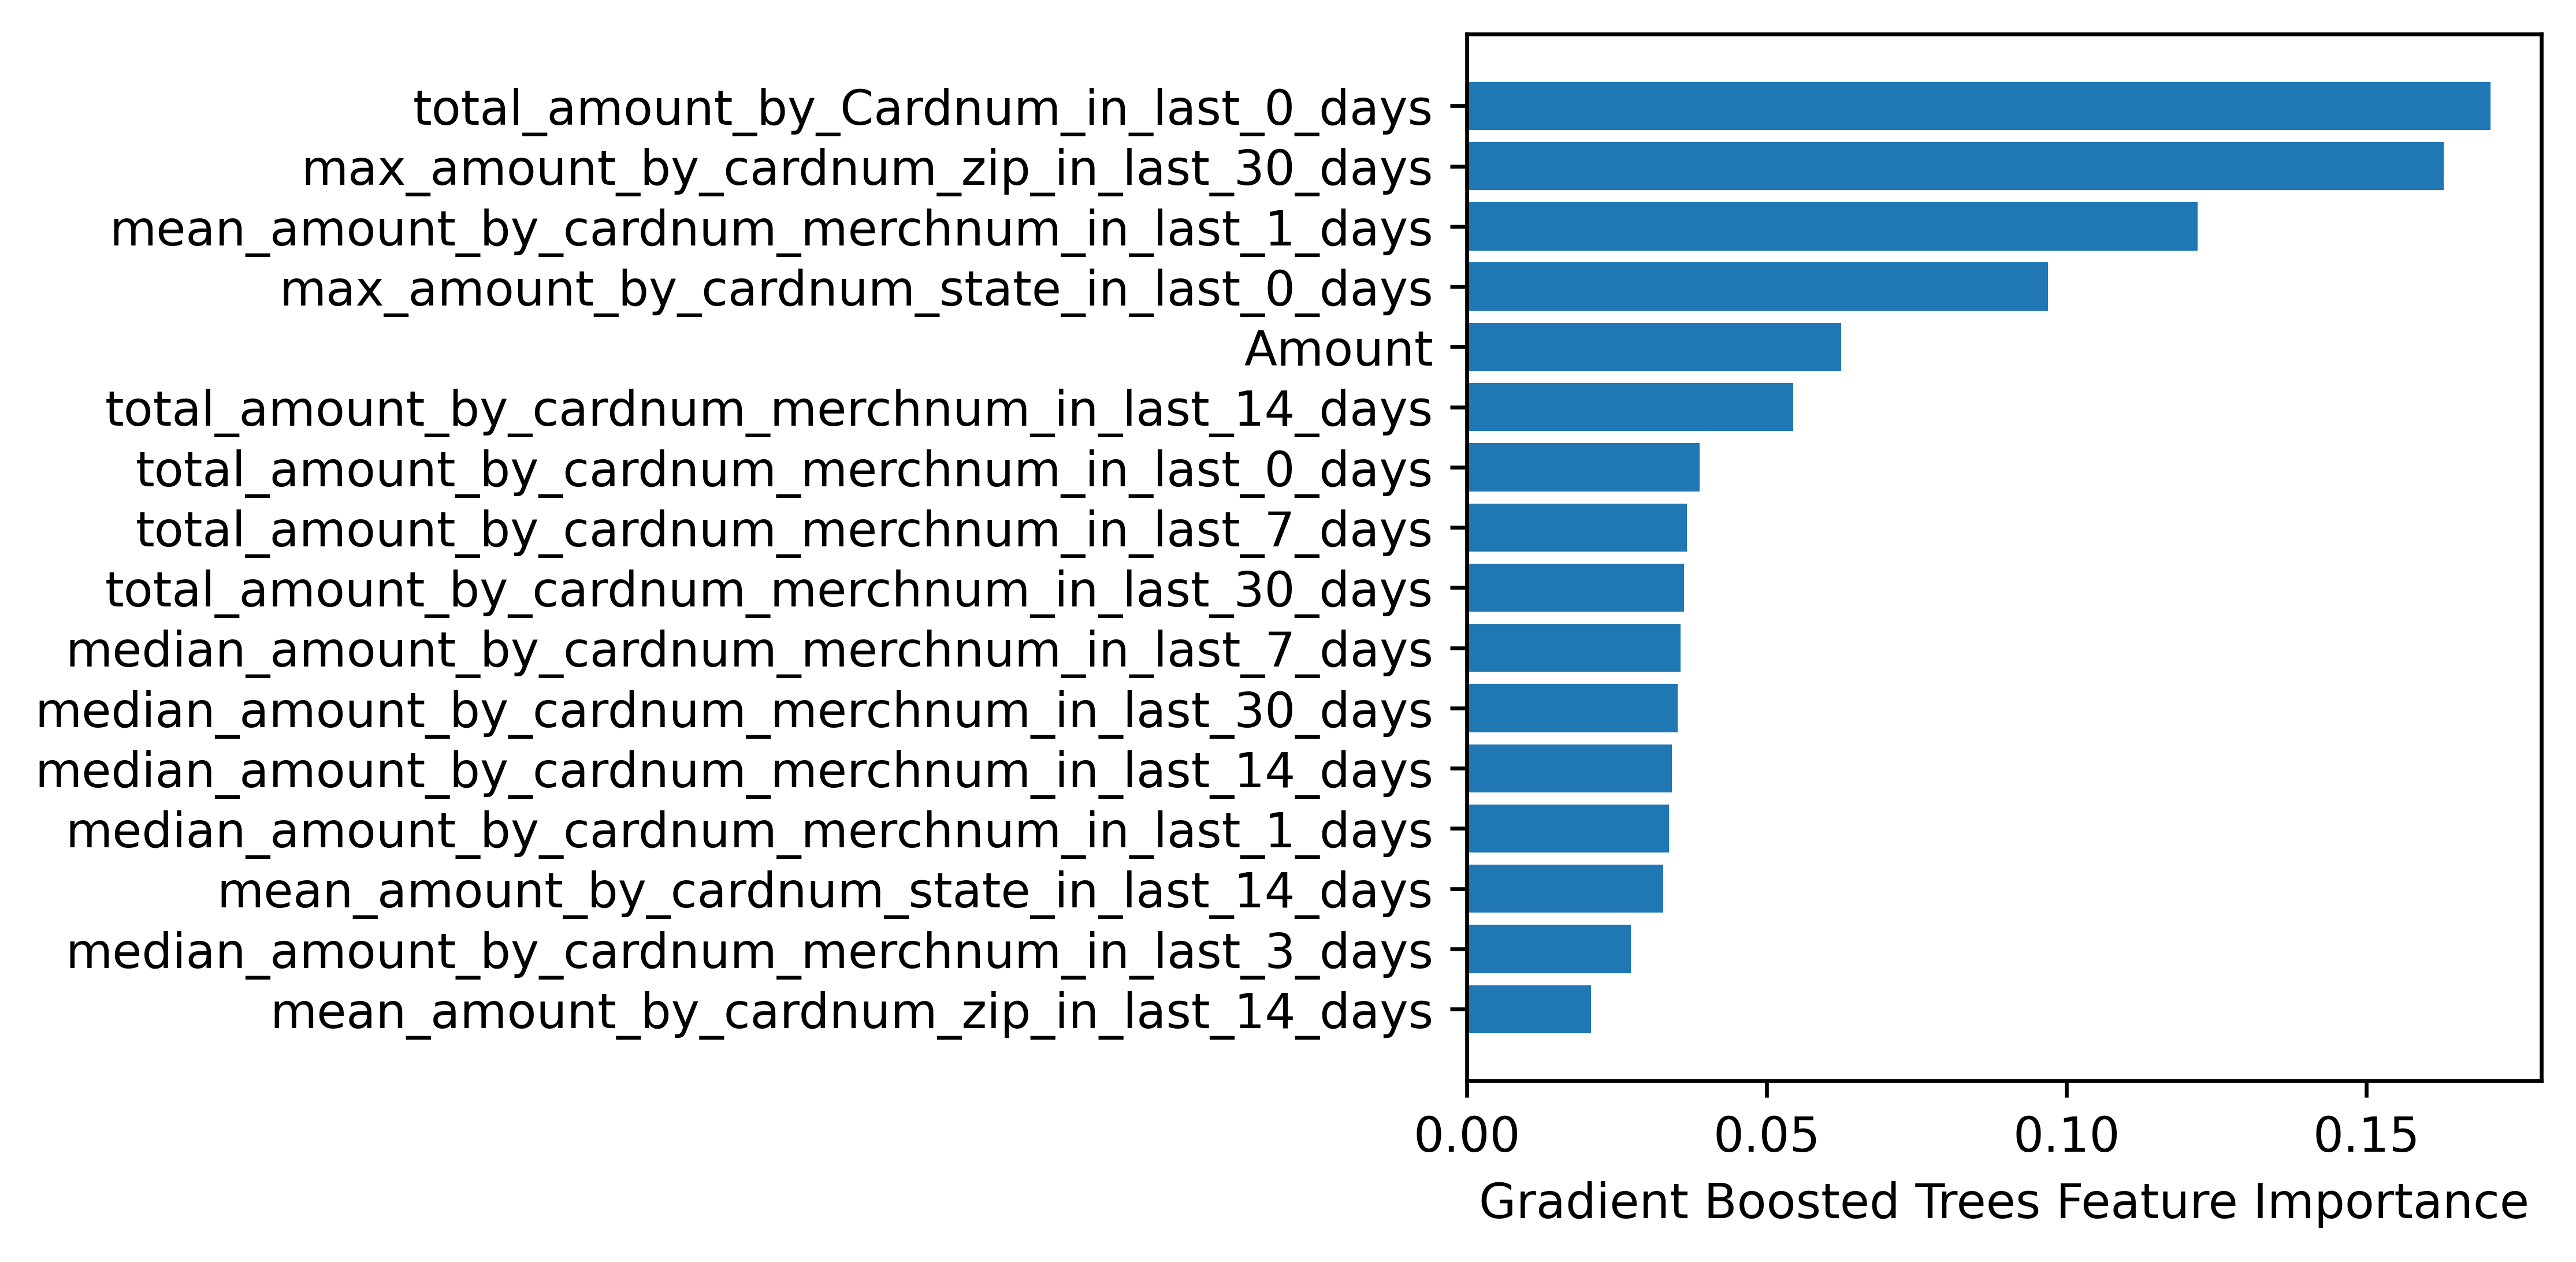

In [5]:
from matplotlib import pyplot as plt## plot the top 10 features in terms of Gini index
mod = bt3

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
sorted_idx = mod.feature_importances_.argsort() ## remove [-10:] to get a plot for all features
plt.barh(X_train.columns[sorted_idx], mod.feature_importances_[sorted_idx])
plt.xlabel("Gradient Boosted Trees Feature Importance")
plt.show()

In [6]:
final_results_df.to_csv('FinalGradientBoostedResults_2.csv')